In [2]:
%load_ext autoreload
%autoreload 2

# Predicting Survival on Titanic: Improvement

This notebook presents a continuation on the last notebook as we are trying to achieve
85% accuracy from our 77% base accuracy. We are also trying to implement a better 
workflow using `sklearn`'s `Pipeline`, splitting the train dataset, applying cross-validation, 
spending our time inspecting features to learn more on why, before challenging back
the test dataset from Kaggle.

It would be a fun journey ahead. Stay tuned.

## Importing Libraries

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from src.utils import skim_data
from src.transformers import FamilySizeBinner

## Reading Datasets

In [4]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

Then from `df_train` I can simply created the famous `X` and `y` variables:

In [5]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

## The Workflow

There are several steps that I want to try in this improvement:

- Train-Test Split

Since testing on Kaggle has a limit, it would be best for me to test my model on
a data split from the existing training dataset. I decide to spent 20% of the training
dataset for my local testing process.

- Hyperparameter tuning & cross-validation

Hyperparameter is the external configuration settings

- Refit on all `X` training data
- Evaluation on `y`
- Refit on all `df_train` data
- Evaluation on Kaggle's `df_test` data


### Split Train Dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

Let's see if our datasets have splitted fairly.

In [7]:
(
    y_train.value_counts() / len(y_train)
)

Survived
0    0.616573
1    0.383427
Name: count, dtype: float64

In [8]:
(
    y_test.value_counts() / len(y_test)
)

Survived
0    0.614525
1    0.385475
Name: count, dtype: float64

Both `y_train` and `y_test` have been splitted fairly, with class `0` stands at
61% and class `1` stands at 38%.

### Hypertuning Parameters & Cross-Validation

Thanks to `sklearn`'s `GridSearchVC`, we can run the hypertuning parameters and
cross-validation in one go. There are two things that we need to decide before
running them all:

- Data Preprocessing and Feature Engineering
- Define Parameter Grid

#### Data Preprocessing & Feature Engineering

In our previous exploration, we already defined how we done both the data processing
and feature engineering:

- Extracts `Title` from `Name`, whilst replacing the rare ones.
- Creates a `HasCabin` feature
- Imputes missing `Age` values based on the `Title`.
- Imputes missing `Embarked` values based on the mode, which is `S` for Southampton.
- Encode the `Sex`, `Embarked`, and `Title`, which are the categorical features,
by using `OneHotEncoding`.
- Encode the `Pclass`, `Age`, `SibSp`, `Parch`, and `Fare`, which are the numerical
features, by using `StandardScaler`.
- Drop any features that aren't mentioned.

But after exploring the discussion related to the challenge, I would like to test
for a new feature, whether it's significant or not. It's called `family_size`, which
combines the values of `SibSp` and `Parch` and adds one for the individual themselves.
Let's try it out first before putting the previous processes into the pipeline.

##### `FamilySize` Matters

We'll start comparing it against the average of survived people.

<Axes: xlabel='FamilySize', ylabel='Survived'>

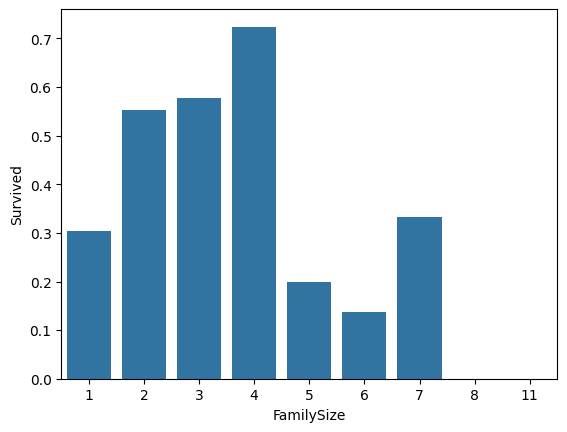

In [9]:
df_test = df_train.copy()

df_test = (
    df_test
    .assign(
        FamilySize=lambda x: x['SibSp'] + x['Parch'] + 1
    )
    .groupby('FamilySize', as_index=False)
    .agg({'Survived': 'mean'})
)

sns.barplot(data=df_test, x='FamilySize', y='Survived')

We can see that there is an apparent distinction comes from family size 1, 
family size 2-4, and family size > 5. Based on this distinction, I would create 
a binned property that divides this into three parts: small (family size 1), 
medium (family size 2-4), and large (family size > 5). This is also because
binned properties are better used when utilizing linear-typed models. Since
I'm using LinearSVC, in theory it would fit perfectly.

In [10]:
bins = [0, 1, 4, np.inf]
labels = ['small', 'medium', 'large']

df_test['FamilyBin'] = pd.cut(df_test['FamilySize'], bins=bins, labels=labels)

df_test

,FamilySize,Survived,FamilyBin
0,1,0.303538,small
1,2,0.552795,medium
2,3,0.578431,medium
3,4,0.724138,medium
4,5,0.200000,large
5,6,0.136364,large
6,7,0.333333,large
7,8,0.000000,large
8,11,0.000000,large


<Axes: xlabel='FamilyBin', ylabel='Survived'>

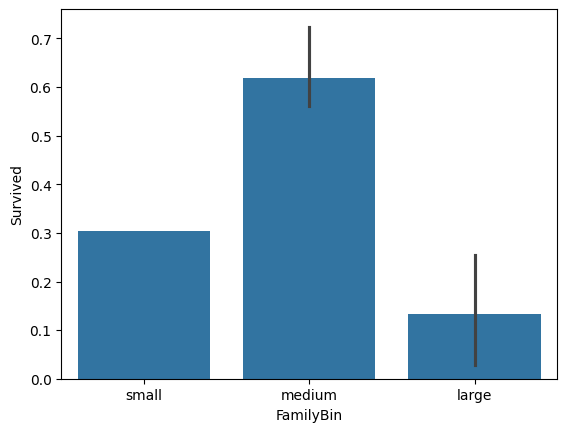

In [13]:
sns.barplot(data=df_test, x='FamilyBin', y='Survived')

I have created a separate function called `FamilySizeBinner`. Let's try it:

In [20]:
df_test = df_train.copy()
family_binner = FamilySizeBinner(drop_originals=False)
df_test = family_binner.fit_transform(df_test)

display(df_test.head())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,medium
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,medium
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,small
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,medium
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,small
